In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=6c938f0ab0a508a8439adbb7c9cb0a8362fa33ec35c06935d25668e6dda00943
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import chess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet50
from typing import List, Tuple
import torch.optim as optim
import time
from tqdm import tqdm

seed = 123456
np.random.seed(seed=seed)

# Разработка модели


In [3]:
class DualHeadChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)

        self._validate_data()
        self.piece_to_idx = {
            "P": 0,
            "N": 1,
            "B": 2,
            "R": 3,
            "Q": 4,
            "K": 5,
            "p": 6,
            "n": 7,
            "b": 8,
            "r": 9,
            "q": 10,
            "k": 11,
        }

    def _validate_data(self):
        valid_indices = []
        for idx, row in self.df.iterrows():
            try:
                board = chess.Board(row["fen"])
                move = chess.Move.from_uci(row["move"])
                if move in board.legal_moves:
                    valid_indices.append(idx)
            except:
                continue

        self.df = self.df.loc[valid_indices].reset_index(drop=True)
        print(f"Загружено {len(self.df)} валидных позиций")

    def _board_to_tensor(self, fen: str) -> torch.Tensor:
        board = chess.Board(fen)
        tensor = torch.zeros(20, 8, 8, dtype=torch.float32)

        # Фигуры (плоскости 0-11)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                row, col = square // 8, square % 8
                piece_idx = self.piece_to_idx[piece.symbol()]
                tensor[piece_idx, row, col] = 1.0

        # Чей ход (плоскость 12)
        tensor[12] = 1.0 if board.turn else 0.0

        # Рокировки (плоскости 13-16)
        castling_rights = [
            board.has_kingside_castling_rights(chess.WHITE),
            board.has_queenside_castling_rights(chess.WHITE),
            board.has_kingside_castling_rights(chess.BLACK),
            board.has_queenside_castling_rights(chess.BLACK),
        ]
        for i, has_right in enumerate(castling_rights):
            if has_right:
                tensor[13 + i] = 1.0

        # Взятие на проходе (плоскость 17)
        if board.ep_square is not None:
            row, col = board.ep_square // 8, board.ep_square % 8
            tensor[17, row, col] = 1.0

        # Счетчик полуходов (плоскость 18)
        tensor[18] = board.halfmove_clock / 50.0

        # Номер хода (плоскость 19)
        tensor[19] = board.fullmove_number / 500.0

        return tensor

    def _move_to_dual_labels(self, move_uci: str, fen: str) -> tuple:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        from_square = move.from_square

        # Для to_square учитываем превращения
        # ДИАПАЗОН ДОЛЖЕН БЫТЬ 0-68 (69 классов)
        # print(move.promotion)
        if move.promotion:
            # Кодируем превращения: 64-68
            to_square = 64 + (move.promotion - 1)  # 64, 65, 66, 67, 68
        else:
            to_square = move.to_square  # 0-63

        # Проверяем, что to_square в правильном диапазоне
        if to_square >= 69:
            raise ValueError(f"Некорректный to_square: {to_square} для хода {move_uci}")

        return from_square, to_square

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row["fen"]
        move = row["move"]

        board_tensor = self._board_to_tensor(fen)
        from_label, to_label = self._move_to_dual_labels(move, fen)

        return board_tensor, from_label, to_label

In [4]:
class ChessDataSplitter:
    def __init__(
        self,
        csv_file,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        random_state=42,
    ):
        print(train_ratio, val_ratio, test_ratio)
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
            "Сумма долей должна быть равна 1"
        )

        self.csv_file = csv_file
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        # Загружаем полный dataset
        self.full_dataset = DualHeadChessDataset(csv_file)

    def split_data(self):
        """Разбивает данные на train/val/test"""
        # Получаем индексы
        n_total = len(self.full_dataset)
        indices = list(range(n_total))

        # Первое разбиение: отделяем test
        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=self.test_ratio,
            random_state=self.random_state,
            shuffle=True,
        )

        # Второе разбиение: разделяем train и val
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.val_ratio / (self.train_ratio + self.val_ratio),
            random_state=self.random_state,
            shuffle=True,
        )

        # Создаем Subset datasets
        train_dataset = Subset(self.full_dataset, train_idx)
        val_dataset = Subset(self.full_dataset, val_idx)
        test_dataset = Subset(self.full_dataset, test_idx)

        print(f"Разбиение завершено:")
        print(
            f"Train: {len(train_dataset)} samples ({len(train_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Val: {len(val_dataset)} samples ({len(val_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Test: {len(test_dataset)} samples ({len(test_dataset) / n_total * 100:.1f}%)"
        )

        return train_dataset, val_dataset, test_dataset

In [5]:
class DualHeadChessModelSimpleAttention(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device

        # ResNet-50 backbone с модификациями
        self.backbone = resnet50(pretrained=True)
        
        # Заменяем первый слой для 20 каналов
        self.backbone.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Получаем все дочерние модули
        backbone_layers = list(self.backbone.children())
        
        # Убираем последние слои (avgpool и classifier)
        self.backbone = nn.Sequential(*backbone_layers[:-2])
        
        # Добавляем свой adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # Простой механизм внимания
        self.attention_conv = nn.Conv2d(2048, 1, 1)
        
        # BatchNorm и Dropout для стабилизации
        self.from_bn1 = nn.BatchNorm1d(256)
        self.from_dropout = nn.Dropout(0.3)
        
        self.to_bn1 = nn.BatchNorm2d(256)
        self.to_bn2 = nn.BatchNorm1d(128)
        self.to_dropout = nn.Dropout(0.3)

        # Голова для исходной клетки
        self.from_fc1 = nn.Linear(2048 * 8 * 8, 256)
        self.from_output = nn.Linear(256, 64)

        # Голова для целевой клетки
        self.to_conv = nn.Conv2d(2048 + 64, 256, 3, padding=1)
        self.to_fc1 = nn.Linear(256 * 8 * 8, 128)
        self.to_output = nn.Linear(128, 69)
        self._initialize_weights()
        self.to(device)

    def _initialize_weights(self):
        """Инициализация весов"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, board_tensor, from_square=None):
        x = self.backbone(board_tensor)
        shared_features = self.adaptive_pool(x)
        attention_weights = F.softmax(
            self.attention_conv(shared_features).view(shared_features.size(0), -1), dim=1
        ).view(shared_features.size(0), 1, 8, 8)
        shared_features = shared_features * attention_weights

        # Голова для исходной клетки
        from_flat = shared_features.reshape(shared_features.size(0), -1)
        from_hidden = F.relu(self.from_fc1(from_flat))
        from_hidden = self.from_bn1(from_hidden)
        from_hidden = self.from_dropout(from_hidden)
        from_logits = self.from_output(from_hidden)
        from_probs = F.log_softmax(from_logits, dim=1)

        if from_square is None:
            return from_probs, None

        # Создаем one-hot кодирование на том же устройстве
        batch_size = shared_features.size(0)
        from_onehot = torch.zeros(batch_size, 64, 8, 8, device=shared_features.device)
        
        # Используем правильные индексы
        batch_indices = torch.arange(batch_size, device=shared_features.device)
        from_onehot[batch_indices, from_square, :, :] = 1

        to_input = torch.cat([shared_features, from_onehot], dim=1)
        to_features = F.relu(self.to_conv(to_input))
        to_features = self.to_bn1(to_features)
        to_flat = to_features.reshape(to_features.size(0), -1)
        to_hidden = F.relu(self.to_fc1(to_flat))
        to_hidden = self.to_bn2(to_hidden)
        to_hidden = self.to_dropout(to_hidden)
        to_logits = self.to_output(to_hidden)
        to_probs = F.log_softmax(to_logits, dim=1)

        return from_probs, to_probs

In [6]:
class ChessTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        device="cpu",
        lr=0.01,
        weight_decay=0.1,
        step_size=5,
        gamma=0.8
    ):
        self.device = device
        self.model = model.to(device)  # Сначала устанавливаем устройство, потом переносим модель
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.lr = lr
        self.weight_decay = weight_decay
        self.step_size = step_size
        self.gamma = gamma

        # Функции потерь для двух голов
        self.from_criterion = nn.CrossEntropyLoss()
        self.to_criterion = nn.CrossEntropyLoss()

        # Оптимизатор
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

        # Планировщик learning rate
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=self.step_size, gamma=self.gamma
        )

        # История обучения
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_from_acc": [],
            "train_to_acc": [],
            "val_from_acc": [],
            "val_to_acc": [],
            "learning_rate": [],
        }

    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.train()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        train_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, (boards, from_targets, to_targets) in enumerate(train_bar):
            # Перемещаем ВСЕ данные на device
            boards = boards.to(self.device)
            from_targets = from_targets.to(self.device)
            to_targets = to_targets.to(self.device)

            # Обнуляем градиенты
            self.optimizer.zero_grad()

            # Прямой проход - получаем обе головы
            from_probs, to_probs = self.model(boards, from_targets)

            # Вычисляем потери для обеих голов
            from_loss = self.from_criterion(from_probs, from_targets)
            to_loss = self.to_criterion(to_probs, to_targets)
            
            # Комбинируем потери
            total_batch_loss = from_loss + to_loss

            # Обратный проход
            total_batch_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Шаг оптимизатора
            self.optimizer.step()

            # Статистика
            total_loss += total_batch_loss.item()
            batch_size = boards.size(0)
            total_samples += batch_size

            # Точность для from-головы
            from_preds = torch.argmax(from_probs, dim=1)
            from_correct = (from_preds == from_targets).sum().item()
            total_from_correct += from_correct

            # Точность для to-головы
            to_preds = torch.argmax(to_probs, dim=1)
            to_correct = (to_preds == to_targets).sum().item()
            total_to_correct += to_correct

            # Обновляем progress bar
            train_bar.set_postfix({
                "Total Loss": f"{total_batch_loss.item():.4f}",
                "From Loss": f"{from_loss.item():.4f}",
                "To Loss": f"{to_loss.item():.4f}",
                "From Acc": f"{from_correct / batch_size:.3f}",
                "To Acc": f"{to_correct / batch_size:.3f}"
            })

        # Вычисляем средние метрики за эпоху
        avg_loss = total_loss / len(self.train_loader)
        from_accuracy = total_from_correct / total_samples
        to_accuracy = total_to_correct / total_samples

        return avg_loss, from_accuracy, to_accuracy

    def validate(self):
        """Валидация модели"""
        self.model.eval()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.val_loader, desc="Validation"
            ):
                # Перемещаем ВСЕ данные на device
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Прямой проход
                from_probs, to_probs = self.model(boards, from_targets)

                # Потери
                from_loss = self.from_criterion(from_probs, from_targets)
                to_loss = self.to_criterion(to_probs, to_targets)
                total_batch_loss = from_loss + to_loss

                total_loss += total_batch_loss.item()
                batch_size = boards.size(0)
                total_samples += batch_size

                # Точность
                from_preds = torch.argmax(from_probs, dim=1)
                to_preds = torch.argmax(to_probs, dim=1)
                
                from_correct = (from_preds == from_targets).sum().item()
                to_correct = (to_preds == to_targets).sum().item()
                
                total_from_correct += from_correct
                total_to_correct += to_correct

        avg_loss = total_loss / len(self.val_loader)
        from_accuracy = total_from_correct / total_samples
        to_accuracy = total_to_correct / total_samples

        return avg_loss, from_accuracy, to_accuracy

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Полный цикл обучения"""
        best_val_loss = float("inf")
        patience_counter = 0

        print("Начало обучения DualHead модели...")
        print(f"Используется устройство: {self.device}")
        print(f"Размер тренировочного набора: {len(self.train_loader.dataset)}")
        print(f"Размер валидационного набора: {len(self.val_loader.dataset)}")
        print(f"Архитектура: DualHead с механизмом внимания")

        for epoch in range(num_epochs):
            print(f"\nЭпоха {epoch + 1}/{num_epochs}")
            print("-" * 50)

            # Обучение
            train_loss, train_from_acc, train_to_acc = self.train_epoch()

            # Валидация
            val_loss, val_from_acc, val_to_acc = self.validate()

            # Обновление learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]["lr"]

            # Сохраняем историю
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_from_acc"].append(train_from_acc)
            self.history["train_to_acc"].append(train_to_acc)
            self.history["val_from_acc"].append(val_from_acc)
            self.history["val_to_acc"].append(val_to_acc)
            self.history["learning_rate"].append(current_lr)

            # Выводим результаты
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train From Acc: {train_from_acc:.4f} | Val From Acc: {val_from_acc:.4f}")
            print(f"Train To Acc: {train_to_acc:.4f} | Val To Acc: {val_to_acc:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Сохранение лучшей модели
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model("best_dualhead_chess_model.pth")
                print("Сохранена лучшая модель!")
            else:
                patience_counter += 1
                print(f"Early stopping: {patience_counter}/{early_stopping_patience}")

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print("Ранняя остановка!")
                break

        print("\nОбучение завершено!")
        self.plot_training_history()

    def evaluate(self):
        """Финальная оценка на тестовом наборе"""
        print("\nОценка на тестовом наборе...")
        self.model.eval()

        total_from_correct = 0
        total_to_correct = 0
        total_full_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.test_loader, desc="Testing"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Прямой проход - сначала получаем предсказания from_square
                from_probs, _ = self.model(boards)
                from_preds = torch.argmax(from_probs, dim=1)

                # Затем используем предсказанные from_square для to-головы
                _, to_probs = self.model(boards, from_preds)
                to_preds = torch.argmax(to_probs, dim=1)

                # Подсчет правильных предсказаний
                batch_size = boards.size(0)
                total_samples += batch_size

                # Точность для from-square
                from_correct = (from_preds == from_targets).sum().item()
                total_from_correct += from_correct

                # Точность для to-square
                to_correct = (to_preds == to_targets).sum().item()
                total_to_correct += to_correct

                # Полная точность (оба предсказания правильные)
                full_correct = ((from_preds == from_targets) & (to_preds == to_targets)).sum().item()
                total_full_correct += full_correct

        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples
        full_acc = total_full_correct / total_samples

        print(f"\nРезультаты на тестовом наборе:")
        print(f"Full Move Accuracy (оба правильные): {full_acc:.4f}")
        print(f"From-square Accuracy: {from_acc:.4f}")
        print(f"To-square Accuracy: {to_acc:.4f}")

        return full_acc, from_acc, to_acc

    def predict_move(self, board_tensor):
        """Предсказание хода для одной позиции"""
        self.model.eval()
        with torch.no_grad():
            board_tensor = board_tensor.unsqueeze(0).to(self.device)
            
            # Первый проход - предсказание from_square
            from_probs, _ = self.model(board_tensor)
            from_square = torch.argmax(from_probs, dim=1).item()
            
            # Второй проход - предсказание to_square с использованием from_square
            _, to_probs = self.model(board_tensor, torch.tensor([from_square], device=self.device))
            to_square = torch.argmax(to_probs, dim=1).item()
            
            # Определяем тип хода
            if to_square >= 64:
                promotion_type = to_square - 63  # 1=queen, 2=rook, etc.
                actual_to_square = to_square - 64
                move_type = "promotion"
            else:
                promotion_type = 0
                actual_to_square = to_square
                move_type = "normal"
            
            return {
                'from_square': from_square,
                'to_square': actual_to_square,
                'promotion_type': promotion_type,
                'move_type': move_type,
                'from_confidence': torch.softmax(from_probs, dim=1)[0, from_square].item(),
                'to_confidence': torch.softmax(to_probs, dim=1)[0, to_square].item()
            }

    def save_model(self, path):
        """Сохранение модели"""
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "history": self.history,
            },
            path,
        )

    def load_model(self, path):
        """Загрузка модели"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.history = checkpoint["history"]

    def plot_training_history(self):
        """Визуализация истории обучения"""
        import matplotlib.pyplot as plt

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Потери
        ax1.plot(self.history["train_loss"], label="Train Loss")
        ax1.plot(self.history["val_loss"], label="Val Loss")
        ax1.set_title("Общие потери")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        # Точность from-square
        ax2.plot(self.history["train_from_acc"], label="Train From Acc")
        ax2.plot(self.history["val_from_acc"], label="Val From Acc")
        ax2.set_title("Точность From-square")
        ax2.set_xlabel("Эпоха")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        # Точность to-square
        ax3.plot(self.history["train_to_acc"], label="Train To Acc")
        ax3.plot(self.history["val_to_acc"], label="Val To Acc")
        ax3.set_title("Точность To-square")
        ax3.set_xlabel("Эпоха")
        ax3.set_ylabel("Accuracy")
        ax3.legend()
        ax3.grid(True)

        # Learning rate
        ax4.plot(self.history["learning_rate"])
        ax4.set_title("Learning Rate")
        ax4.set_xlabel("Эпоха")
        ax4.set_ylabel("LR")
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig("dualhead_training_history.png", dpi=300, bbox_inches="tight")
        plt.show()

In [7]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используется устройство: {device}")

    torch.cuda.empty_cache()

    # Загрузка данных
    print("Загрузка данных...")
    splitter = ChessDataSplitter(
        test_ratio=0.01,
        val_ratio=0.2 * (1 - 0.01),
        train_ratio=0.8 * (1 - 0.01),
        csv_file="/kaggle/input/fens-training-set/fens_training_set.csv",
        random_state=seed
    )
    train_dataset, val_dataset, test_dataset = splitter.split_data()
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Модель
    print("Инициализация модели...")
    model = DualHeadChessModelSimpleAttention()

    # Тренер
    trainer = ChessTrainer(model
                           ,train_loader
                           ,val_loader
                           ,test_loader
                           ,device
                           ,lr=1e-2
                           ,weight_decay=0.5
                           ,step_size=4
                           ,gamma=0.3)

    # Обучение
    trainer.train(num_epochs=20, early_stopping_patience=10)

    # Валидация
    trainer.validate()

    # # Сохранение финальной модели
    # trainer.save_model("final_chess_model.pth")
    # print("Модель сохранена!")

Используется устройство: cuda
Загрузка данных...
0.792 0.198 0.01
Загружено 268549 валидных позиций
Разбиение завершено:
Train: 212690 samples (79.2%)
Val: 53173 samples (19.8%)
Test: 2686 samples (1.0%)
Инициализация модели...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Начало обучения DualHead модели...
Используется устройство: cuda
Размер тренировочного набора: 212690
Размер валидационного набора: 53173
Архитектура: DualHead с механизмом внимания

Эпоха 1/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.43it/s]


Train Loss: 6.4263 | Val Loss: 6.4165
Train From Acc: 0.0756 | Val From Acc: 0.0660
Train To Acc: 0.2493 | Val To Acc: 0.2584
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 2/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.87it/s]


Train Loss: 5.9620 | Val Loss: 6.7099
Train From Acc: 0.1388 | Val From Acc: 0.0651
Train To Acc: 0.2630 | Val To Acc: 0.2439
Learning Rate: 0.010000
Early stopping: 1/10

Эпоха 3/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.64it/s]


Train Loss: 5.7900 | Val Loss: 6.0385
Train From Acc: 0.1811 | Val From Acc: 0.1098
Train To Acc: 0.2675 | Val To Acc: 0.2478
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 4/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.22it/s]


Train Loss: 5.6451 | Val Loss: 6.7967
Train From Acc: 0.2122 | Val From Acc: 0.0747
Train To Acc: 0.2717 | Val To Acc: 0.2528
Learning Rate: 0.003000
Early stopping: 1/10

Эпоха 5/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.94it/s]


Train Loss: 5.3770 | Val Loss: 5.6017
Train From Acc: 0.2465 | Val From Acc: 0.2149
Train To Acc: 0.2922 | Val To Acc: 0.2860
Learning Rate: 0.003000
Сохранена лучшая модель!

Эпоха 6/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.12it/s]


Train Loss: 5.2588 | Val Loss: 6.2485
Train From Acc: 0.2632 | Val From Acc: 0.1339
Train To Acc: 0.2982 | Val To Acc: 0.2791
Learning Rate: 0.003000
Early stopping: 1/10

Эпоха 7/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.64it/s]


Train Loss: 5.1645 | Val Loss: 5.8247
Train From Acc: 0.2755 | Val From Acc: 0.1209
Train To Acc: 0.3026 | Val To Acc: 0.2914
Learning Rate: 0.003000
Early stopping: 2/10

Эпоха 8/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.32it/s]


Train Loss: 5.1046 | Val Loss: 5.4762
Train From Acc: 0.2862 | Val From Acc: 0.2002
Train To Acc: 0.3045 | Val To Acc: 0.3016
Learning Rate: 0.000900
Сохранена лучшая модель!

Эпоха 9/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.14it/s]


Train Loss: 4.8705 | Val Loss: 4.8748
Train From Acc: 0.3127 | Val From Acc: 0.2983
Train To Acc: 0.3234 | Val To Acc: 0.3289
Learning Rate: 0.000900
Сохранена лучшая модель!

Эпоха 10/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.43it/s]


Train Loss: 4.7927 | Val Loss: 5.0319
Train From Acc: 0.3207 | Val From Acc: 0.2649
Train To Acc: 0.3292 | Val To Acc: 0.3289
Learning Rate: 0.000900
Early stopping: 1/10

Эпоха 11/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.93it/s]


Train Loss: 4.7522 | Val Loss: 4.9512
Train From Acc: 0.3254 | Val From Acc: 0.2814
Train To Acc: 0.3332 | Val To Acc: 0.3254
Learning Rate: 0.000900
Early stopping: 2/10

Эпоха 12/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:16<00:00, 24.56it/s]


Train Loss: 4.7218 | Val Loss: 4.8328
Train From Acc: 0.3280 | Val From Acc: 0.3042
Train To Acc: 0.3344 | Val To Acc: 0.3323
Learning Rate: 0.000270
Сохранена лучшая модель!

Эпоха 13/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.05it/s]


Train Loss: 4.5971 | Val Loss: 4.6370
Train From Acc: 0.3415 | Val From Acc: 0.3219
Train To Acc: 0.3473 | Val To Acc: 0.3469
Learning Rate: 0.000270
Сохранена лучшая модель!

Эпоха 14/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.38it/s]


Train Loss: 4.5557 | Val Loss: 4.5319
Train From Acc: 0.3456 | Val From Acc: 0.3403
Train To Acc: 0.3522 | Val To Acc: 0.3530
Learning Rate: 0.000270
Сохранена лучшая модель!

Эпоха 15/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:16<00:00, 24.56it/s]


Train Loss: 4.5307 | Val Loss: 4.6721
Train From Acc: 0.3489 | Val From Acc: 0.3067
Train To Acc: 0.3534 | Val To Acc: 0.3415
Learning Rate: 0.000270
Early stopping: 1/10

Эпоха 16/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.35it/s]


Train Loss: 4.5093 | Val Loss: 4.5744
Train From Acc: 0.3492 | Val From Acc: 0.3335
Train To Acc: 0.3550 | Val To Acc: 0.3491
Learning Rate: 0.000081
Early stopping: 2/10

Эпоха 17/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 23.99it/s]


Train Loss: 4.4463 | Val Loss: 4.4176
Train From Acc: 0.3572 | Val From Acc: 0.3537
Train To Acc: 0.3619 | Val To Acc: 0.3604
Learning Rate: 0.000081
Сохранена лучшая модель!

Эпоха 18/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.35it/s]


Train Loss: 4.4281 | Val Loss: 4.4068
Train From Acc: 0.3580 | Val From Acc: 0.3547
Train To Acc: 0.3637 | Val To Acc: 0.3599
Learning Rate: 0.000081
Сохранена лучшая модель!

Эпоха 19/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.33it/s]


Train Loss: 4.4151 | Val Loss: 4.4153
Train From Acc: 0.3599 | Val From Acc: 0.3468
Train To Acc: 0.3648 | Val To Acc: 0.3601
Learning Rate: 0.000081
Early stopping: 1/10

Эпоха 20/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:17<00:00, 24.00it/s]


Train Loss: 4.4022 | Val Loss: 4.3813
Train From Acc: 0.3611 | Val From Acc: 0.3551
Train To Acc: 0.3658 | Val To Acc: 0.3605
Learning Rate: 0.000024
Сохранена лучшая модель!

Обучение завершено!


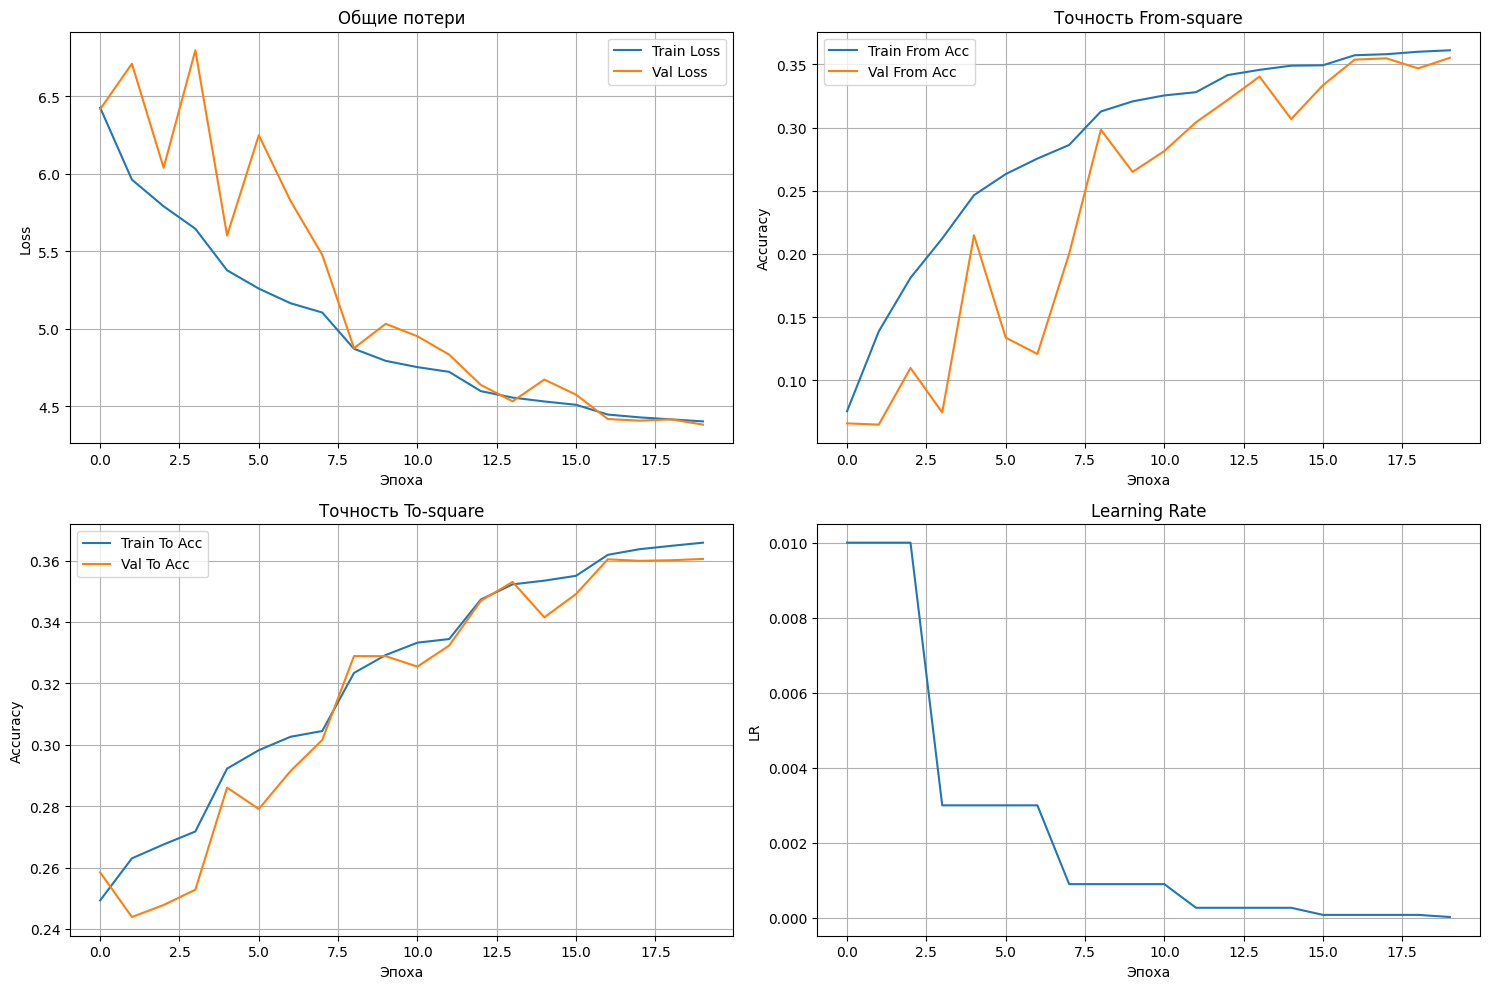

Validation: 100%|██████████| 416/416 [00:17<00:00, 24.20it/s]


In [8]:
if __name__ == "__main__":
    main()